# Toy example

Original notebook by Alexander Held, edited for the MadMiner repository by Johann Brehmer, Irina Espejo, Felix Kling, and Kyle Cranmer 2018-2019.

In this notebook, we use a simple toy example to demonstrate the machine learning and inference algorithms in MadMiner. This allows us to skip many of the more technical steps, and there's no dependency on MadGraph, Pythia, or Delphes.

What this tutorial does not do, is explaining the inference methods. To understand what's happening, please have a look at ["Constraining Effective Field Theories With Machine Learning"](https://arxiv.org/abs/1805.00013), which will explain the basic idea in just a few pages. If you really want to get down to the dirty details, ["A Guide to Constraining Effective Field Theories With Machine Learning"](https://arxiv.org/abs/1805.00020) has you covered.

## Preparations

In [1]:
import os
import logging
import numpy as np
from scipy.stats import norm
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import math

%matplotlib inline

from madminer.ml.ensemble import Ensemble
from madminer.ml import ParameterizedRatioEstimator, ScoreEstimator, BayesianScoreEstimator, HeteroskedasticScoreEstimator, RepulsiveEnsembleScoreEstimator

In [2]:
if not os.path.exists("data"):
    os.makedirs("data")

MadMiner uses the Python `logging` module to provide additional information and debugging output. You can choose how much of this output you want to see by switching the level in the following lines to `logging.DEBUG` or `logging.WARNING`.

In [3]:
# MadMiner output
logging.basicConfig(
    format="%(asctime)-5.5s %(name)-20.20s %(levelname)-7.7s %(message)s",
    datefmt="%H:%M",
    level=logging.INFO,
)

# Output of all other modules (e.g. matplotlib)
for key in logging.Logger.manager.loggerDict:
    if "madminer" not in key:
        logging.getLogger(key).setLevel(logging.WARNING)

## 1. A toy simulator

Our simulator depends on just one parameter `theta` and produces one-dimensional observables `x`. It is characterized by one latent variable `z`. "Running" the simulator consists of two steps:
- "Hard process": a value of `z` is drawn from a normal distribution, where the mean depends on `theta`. 
- "Detector": a value for `x` is drawn from a normal distribution with mean equal to `z`. There is no explicit dependence on `theta`.

As in the particle physics case, we assume that we can calculate the joint likelihood ratio `r(x, z | theta0, theta1)` as well as the joint score `t(x, z | theta)`, which depend explicitly on `z` (and where the "detector" part cancels).

Here are some general settings (feel free to play with them): 

In [4]:
z_std = 2.0
x_std = 1.0

The following function runs the simulator for a value of `theta` and calculates the joint likelihood ratio between `theta0` and `theta1` as well as the joint score at `theta_score`:

In [5]:
def simulate(theta, theta0=None, theta1=None, theta_score=None, npoints=None):
    # Draw latent variables z
    z = np.random.normal(loc=theta, scale=z_std, size=npoints)

    # Draw observables x
    x = np.random.normal(loc=z, scale=x_std, size=None)

    # Calculate joint likelihood ratio and joint score
    if theta0 is not None and theta1 is not None:
        r_xz = norm(loc=theta0, scale=z_std).pdf(z) / norm(loc=theta1, scale=z_std).pdf(z)
    else:
        r_xz = None

    if theta_score is not None:
        t_xz = 2*(z - theta_score) / z_std**2
    else:
        t_xz = None

    return x, r_xz, t_xz

Usually the likelihood function `p(x|theta)` is intractable, but in this toy example it is just given by the convolution of two Gaussians, which is again a Gaussian. We will use this to validate the results later:

In [6]:
def calculate_likelihood_ratio(x, theta0, theta1=0.0):
    combined_std = (z_std**2 + x_std**2) ** 0.5
    r_x = norm(loc=theta0, scale=combined_std).pdf(x) / norm(loc=theta1, scale=combined_std).pdf(x)
    return r_x

## repulsive ensemble

In [7]:
class StackedLinear(nn.Module):
    """
    Efficient implementation of linear layers for ensembles of networks
    """
    def __init__(self, in_features, out_features, channels):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.channels = channels
        self.weight = nn.Parameter(torch.empty((channels, out_features, in_features)))
        self.bias = nn.Parameter(torch.empty((channels, out_features)))
        self.reset_parameters()

    def reset_parameters(self):
        for i in range(self.channels):
            torch.nn.init.kaiming_uniform_(self.weight[i], a=math.sqrt(5))
            fan_in, _ = torch.nn.init._calculate_fan_in_and_fan_out(self.weight[i])
            bound = 1 / math.sqrt(fan_in) if fan_in > 0 else 0
            torch.nn.init.uniform_(self.bias[i], -bound, bound)

    def forward(self, input):
        return torch.baddbmm(self.bias[:,None,:], input, self.weight.transpose(1,2))

def kernel(x, y):
    """
    RBF kernel with median estimator
    """
    channels = len(x)
    dnorm2 = (x.reshape(channels,1,-1) - y.reshape(1,channels,-1)).square().sum(dim=2)
    sigma = torch.quantile(dnorm2.detach(), 0.5) / (2 * math.log(channels + 1))
    return torch.exp(- dnorm2 / (2*sigma))

In [8]:
def train_repulsive_ensemble(x, y):
    channels = 100
    iterations = 1000
    n_samples = len(x)
    prior_width = 1.

    model = nn.Sequential(
        StackedLinear(1, 10, channels),
        nn.ReLU(),
        StackedLinear(10, 10, channels),
        nn.ReLU(),
        StackedLinear(10, 2, channels),
    )
    opt = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1 / (2*n_samples*prior_width**2))
    sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, iterations)

    xt = torch.tensor(x[None,:,None], dtype=torch.float32).expand(channels,-1,-1)
    print("dim of x:", x.shape)
    print("dim of xt:", xt.shape, x[None,:,None].shape)
    yt = torch.tensor(y[None,:], dtype=torch.float32).expand(channels,-1)

    for i in range(iterations):
        h = model(xt)
        mu, log_sigma2 = h[:,:,0], h[:,:,1]
        
        # Heteroscedastic regression loss
        reg = 0.5 * ((yt - mu)**2 / log_sigma2.exp() + log_sigma2)
        
        # repulsive ensemble loss
        k = kernel(reg, reg.detach())
        reg_mean, reg_std = reg.mean(dim=1), reg.std(dim=1)
        loss = torch.sum(reg_mean + (k.sum(dim=1) / k.detach().sum(dim=1) - 1) / len(x), dim=0)
        
        opt.zero_grad()
        loss.backward()
        opt.step()
        sched.step()
        print(f"iteration {i}: loss={loss}")
        if i % 100 == 0:
            print(f"mean={reg_mean.mean().item():.4f}, std={reg_mean.std().item():.4f}, " +
                f"min={reg_mean.min().item():.4f}, max={reg_mean.max().item():.4f}")

    return model

## 2. Run the simulation and generate training data

In [9]:
# number of parameter points to train
n_param_points = 1000

# numerator, uniform prior
theta0 = np.zeros(shape=n_param_points)

# Sample from theta0
x_from_theta0, r_xz_from_theta0, t_xz_from_theta0 = simulate(theta0, theta0, theta0, theta0)

# Combine results and reshape
# x_train = np.hstack((x_from_theta0, x_from_theta1)).reshape(-1, 1)
# r_xz_train = np.hstack((r_xz_from_theta0, r_xz_from_theta1)).reshape(-1, 1)
# t_xz_train = np.hstack((t_xz_from_theta0, t_xz_from_theta1)).reshape(-1, 1)
# y_train = np.hstack((np.zeros_like(x_from_theta0), np.ones_like(np.ones_like(x_from_theta1)))).reshape(-1, 1)
# theta0_train = np.hstack((theta0, theta0)).reshape(-1, 1)
x_train = x_from_theta0
t_xz_train = t_xz_from_theta0

# Save to file
np.save("data/x_train.npy", x_train)
np.save("data/t_xz_train.npy", t_xz_train)

In [10]:
def calculate_true_score(x, theta):
    combined_std = (z_std**2 + x_std**2) ** 0.5
    r_x = 2*(x - theta)/combined_std**2
    return r_x

## 3. Model training

In [11]:
repulsive_ensemble = train_repulsive_ensemble(x_train, t_xz_train)

dim of x: (1000,)
dim of xt: torch.Size([100, 1000, 1]) (1, 1000, 1)
iteration 0: loss=58.074546813964844
mean=0.5807, std=0.2107, min=0.3568, max=1.7103
iteration 1: loss=49.54222869873047
iteration 2: loss=43.184288024902344
iteration 3: loss=38.11335372924805
iteration 4: loss=33.78380584716797
iteration 5: loss=29.90736961364746
iteration 6: loss=26.3616886138916
iteration 7: loss=23.073917388916016
iteration 8: loss=19.984149932861328
iteration 9: loss=17.06513214111328
iteration 10: loss=14.293351173400879
iteration 11: loss=11.667648315429688
iteration 12: loss=9.183113098144531
iteration 13: loss=6.766719341278076
iteration 14: loss=4.444530963897705
iteration 15: loss=2.252091884613037
iteration 16: loss=0.12450623512268066
iteration 17: loss=-1.8908162117004395
iteration 18: loss=-3.8263444900512695
iteration 19: loss=-5.658237934112549
iteration 20: loss=-7.352386474609375
iteration 21: loss=-8.966806411743164
iteration 22: loss=-10.441344261169434
iteration 23: loss=-11.798

In [58]:
# import cProfile

repulsive_ensemble_sally = RepulsiveEnsembleScoreEstimator(n_hidden=(10, 10), activation="relu")

# cProfile.run("""
repulsive_ensemble_sally.train(
    method="repulsive_ensemble_sally",
    x="data/x_train.npy",
    t_xz="data/t_xz_train.npy",
    n_epochs=1000,
    initial_lr=0.001,
    optimizer_kwargs={"weight_decay": 1.0 / (2 * n_param_points * 1.0**2)},
    scheduler=True
)
# """, "trainstats")
repulsive_ensemble_sally.save("models/repulsive_ensemble_sally")

14:10 madminer.ml.score    INFO    Starting training
14:10 madminer.ml.score    INFO      Batch size:             128
14:10 madminer.ml.score    INFO      Optimizer:              amsgrad
14:10 madminer.ml.score    INFO      Epochs:                 1000
14:10 madminer.ml.score    INFO      Learning rate:          0.001 initially, decaying to 0.0001
14:10 madminer.ml.score    INFO      Validation split:       0.25
14:10 madminer.ml.score    INFO      Early stopping:         True
14:10 madminer.ml.score    INFO      Scale inputs:           True
14:10 madminer.ml.score    INFO      Shuffle labels          False
14:10 madminer.ml.score    INFO      Samples:                all
14:10 madminer.ml.score    INFO    Loading training data
14:10 madminer.utils.vario INFO      Loading data/x_train.npy into RAM
14:10 madminer.utils.vario INFO      Loading data/t_xz_train.npy into RAM
14:10 madminer.ml.score    INFO    Found 1000 samples with 1 parameters and 1 observables
14:10 madminer.ml.base     I

In [13]:
sally = ScoreEstimator(n_hidden=(20, 20))

sally.train(
    method="sally",
    x="data/x_train.npy",
    t_xz="data/t_xz_train.npy",
    n_epochs=100
)

sally.save("models/sally")

13:29 madminer.ml.score    INFO    Starting training
13:29 madminer.ml.score    INFO      Batch size:             128
13:29 madminer.ml.score    INFO      Optimizer:              amsgrad
13:29 madminer.ml.score    INFO      Epochs:                 100
13:29 madminer.ml.score    INFO      Learning rate:          0.001 initially, decaying to 0.0001
13:29 madminer.ml.score    INFO      Validation split:       0.25
13:29 madminer.ml.score    INFO      Early stopping:         True
13:29 madminer.ml.score    INFO      Scale inputs:           True
13:29 madminer.ml.score    INFO      Shuffle labels          False
13:29 madminer.ml.score    INFO      Samples:                all
13:29 madminer.ml.score    INFO    Loading training data
13:29 madminer.utils.vario INFO      Loading data/x_train.npy into RAM
13:29 madminer.utils.vario INFO      Loading data/t_xz_train.npy into RAM
13:29 madminer.ml.score    INFO    Found 1000 samples with 1 parameters and 1 observables
13:29 madminer.ml.base     IN

In [14]:
n_estimators = 100
estimators = [
    ScoreEstimator(n_hidden=(20, 20), activation='relu') for i in range(n_estimators)
]
ensemble = Ensemble(estimators)
for i, _ in enumerate(estimators):
    ensemble.train_one(i,
        method="sally",
        x="data/x_train.npy",
        t_xz="data/t_xz_train.npy",
        n_epochs=100,
    )
    estimators[i].save(f"models/sally_{i}")

ensemble.save(f"models/sally_ensemble")

13:30 madminer.ml.score    INFO    Starting training
13:30 madminer.ml.score    INFO      Batch size:             128
13:30 madminer.ml.score    INFO      Optimizer:              amsgrad
13:30 madminer.ml.score    INFO      Epochs:                 100
13:30 madminer.ml.score    INFO      Learning rate:          0.001 initially, decaying to 0.0001
13:30 madminer.ml.score    INFO      Validation split:       0.25
13:30 madminer.ml.score    INFO      Early stopping:         True
13:30 madminer.ml.score    INFO      Scale inputs:           True
13:30 madminer.ml.score    INFO      Shuffle labels          False
13:30 madminer.ml.score    INFO      Samples:                all
13:30 madminer.ml.score    INFO    Loading training data
13:30 madminer.utils.vario INFO      Loading data/x_train.npy into RAM
13:30 madminer.utils.vario INFO      Loading data/t_xz_train.npy into RAM
13:30 madminer.ml.score    INFO    Found 1000 samples with 1 parameters and 1 observables
13:30 madminer.ml.base     IN

In [12]:
heteroskedastic_sally = HeteroskedasticScoreEstimator(n_hidden=(20, 20), activation='relu')

heteroskedastic_sally.train(
    method="heteroskedastic_sally",
    x="data/x_train.npy",
    t_xz="data/t_xz_train.npy",
    n_epochs=500,
    initial_lr=0.01,
)

heteroskedastic_sally.save("models/heteroskedastic_sally")

09:54 madminer.ml.score    INFO    Starting training
09:54 madminer.ml.score    INFO      Batch size:             128
09:54 madminer.ml.score    INFO      Optimizer:              amsgrad
09:54 madminer.ml.score    INFO      Epochs:                 500
09:54 madminer.ml.score    INFO      Learning rate:          0.01 initially, decaying to 0.0001
09:54 madminer.ml.score    INFO      Validation split:       0.25
09:54 madminer.ml.score    INFO      Early stopping:         True
09:54 madminer.ml.score    INFO      Scale inputs:           True
09:54 madminer.ml.score    INFO      Shuffle labels          False
09:54 madminer.ml.score    INFO      Samples:                all
09:54 madminer.ml.score    INFO    Loading training data
09:54 madminer.utils.vario INFO      Loading data/x_train.npy into RAM
09:54 madminer.utils.vario INFO      Loading data/t_xz_train.npy into RAM
09:54 madminer.ml.score    INFO    Found 1000 samples with 1 parameters and 1 observables
09:54 madminer.ml.base     INF

09:54 madminer.utils.ml.tr INFO      Epoch  25: train loss -0.28737 (heteroskedastic_loss: -0.287)
09:54 madminer.utils.ml.tr INFO                 val. loss  -0.14896 (heteroskedastic_loss: -0.149)
09:54 madminer.utils.ml.tr INFO      Epoch  50: train loss -0.29051 (heteroskedastic_loss: -0.291)
09:54 madminer.utils.ml.tr INFO                 val. loss  -0.13445 (heteroskedastic_loss: -0.134)
09:54 madminer.utils.ml.tr INFO      Epoch  75: train loss -0.29132 (heteroskedastic_loss: -0.291)
09:54 madminer.utils.ml.tr INFO                 val. loss  -0.13922 (heteroskedastic_loss: -0.139)
09:54 madminer.utils.ml.tr INFO      Epoch 100: train loss -0.29128 (heteroskedastic_loss: -0.291)
09:54 madminer.utils.ml.tr INFO                 val. loss  -0.13696 (heteroskedastic_loss: -0.137)
09:54 madminer.utils.ml.tr INFO      Epoch 125: train loss -0.29187 (heteroskedastic_loss: -0.292)
09:54 madminer.utils.ml.tr INFO                 val. loss  -0.13715 (heteroskedastic_loss: -0.137)
09:54 madm

In [67]:
bayes_sally = BayesianScoreEstimator(n_hidden=(10, 10), activation='relu')

bayes_sally.train(
    method="bayesian_sally",
    x="data/x_train.npy",
    t_xz="data/t_xz_train.npy",
    n_epochs=100,
    initial_lr=0.01
)

bayes_sally.save("models/bayes_sally")

14:16 madminer.ml.score    INFO    Starting training
14:16 madminer.ml.score    INFO      Batch size:             128
14:16 madminer.ml.score    INFO      Optimizer:              amsgrad
14:16 madminer.ml.score    INFO      Epochs:                 100
14:16 madminer.ml.score    INFO      Learning rate:          0.01 initially, decaying to 0.0001
14:16 madminer.ml.score    INFO      Validation split:       0.25
14:16 madminer.ml.score    INFO      Early stopping:         True
14:16 madminer.ml.score    INFO      Scale inputs:           True
14:16 madminer.ml.score    INFO      Shuffle labels          False
14:16 madminer.ml.score    INFO      Samples:                all
14:16 madminer.ml.score    INFO    Loading training data
14:16 madminer.utils.vario INFO      Loading data/x_train.npy into RAM
14:16 madminer.utils.vario INFO      Loading data/t_xz_train.npy into RAM
14:16 madminer.ml.score    INFO    Found 1000 samples with 1 parameters and 1 observables
14:16 madminer.ml.base     INF

## 5. Evaluation

It's time to evaluate our likelihood ratio estimators!

This is the expected log likelihood ratio over parameter space:

## Score evaluation

In [16]:
n_param_points_test = 10000  # number of parameter points to test
theta_test = 0.0 * np.zeros(shape=n_param_points_test).reshape(-1, 1)
x_test, _, _ = simulate(theta_test)
x_test = np.sort(x_test, axis=0)

np.save("data/x_test.npy", x_test)

In [17]:
xx = torch.linspace(x_test.min(), x_test.max(), 1000)
channels = 100
with torch.no_grad():
    mus = repulsive_ensemble(xx[None,:,None].expand(channels,-1,-1))[:,:,0]
repulsive_ensemble_means = mus.mean(dim=0).numpy()
repulsive_ensemble_stds = mus.std(dim=0).numpy()

In [18]:
sally = ScoreEstimator()
sally.load("models/sally")

t_hat_sally = sally.evaluate(
    theta=np.array([0]),
    x="data/x_test.npy",
)

13:31 madminer.ml.base     INFO    Loading model from models/sally


13:31 madminer.utils.vario INFO      Loading data/x_test.npy into RAM


In [54]:
repulsive_ensemble_sally = RepulsiveEnsembleScoreEstimator()
repulsive_ensemble_sally.load("models/repulsive_ensemble_sally")

t_hat_repulsive_ensemble_sally, t_hat_sig_repulsive_ensemble_sally  = repulsive_ensemble_sally.evaluate(
    theta=np.array([0]),
    x="data/x_test.npy",
)
t_hat_repulsive_ensemble_sally = t_hat_repulsive_ensemble_sally.flatten()
t_hat_sig_repulsive_ensemble_sally = t_hat_sig_repulsive_ensemble_sally.flatten()
t_hat_sig_repulsive_ensemble_sally = np.sqrt(t_hat_sig_repulsive_ensemble_sally)

14:08 madminer.ml.base     INFO    Loading model from models/repulsive_ensemble_sally
14:08 madminer.utils.vario INFO      Loading data/x_test.npy into RAM


In [20]:
sally_ensemble = Ensemble()
sally_ensemble.load("models/sally_ensemble")

t_hat_sally_ensemble, _, t_hat_sig_sally_ensemble = sally_ensemble.evaluate_score(
    # theta=np.array([0]),
    theta=0,
    x="data/x_test.npy",
    calculate_covariance=False,
    calculate_sigma=True
)
t_hat_sally_ensemble = t_hat_sally_ensemble.flatten()
t_hat_sig_sally_ensemble = t_hat_sig_sally_ensemble.flatten()

13:31 madminer.ml.ensemble INFO    Found score ensemble with 100 estimators
13:31 madminer.ml.base     INFO    Loading model from models/sally_ensemble/estimator_0
13:31 madminer.ml.base     INFO    Loading model from models/sally_ensemble/estimator_1
13:31 madminer.ml.base     INFO    Loading model from models/sally_ensemble/estimator_2
13:31 madminer.ml.base     INFO    Loading model from models/sally_ensemble/estimator_3
13:31 madminer.ml.base     INFO    Loading model from models/sally_ensemble/estimator_4
13:31 madminer.ml.base     INFO    Loading model from models/sally_ensemble/estimator_5
13:31 madminer.ml.base     INFO    Loading model from models/sally_ensemble/estimator_6
13:31 madminer.ml.base     INFO    Loading model from models/sally_ensemble/estimator_7
13:31 madminer.ml.base     INFO    Loading model from models/sally_ensemble/estimator_8
13:31 madminer.ml.base     INFO    Loading model from models/sally_ensemble/estimator_9
13:31 madminer.ml.base     INFO    Loading m

In [68]:
bayes_sally = BayesianScoreEstimator()
bayes_sally.load("models/bayes_sally")

t_hat_bayes_sally, t_hat_sig_bayes_sally, t_hat_sig_stoch_bayes_sally, t_hat_sig_tot_bayes_sally = bayes_sally.evaluate(
    theta=np.array([0]),
    x="data/x_test.npy",
)
t_hat_bayes_sally = t_hat_bayes_sally.flatten()
t_hat_sig_bayes_sally = t_hat_sig_bayes_sally.flatten()
t_hat_sig_bayes_sally = t_hat_sig_bayes_sally

14:17 madminer.ml.base     INFO    Loading model from models/bayes_sally
14:17 madminer.utils.vario INFO      Loading data/x_test.npy into RAM


In [22]:
heteroskedastic_sally = HeteroskedasticScoreEstimator()
heteroskedastic_sally.load("models/heteroskedastic_sally")

t_hat_heteroskedastic_sally, t_hat_sig_heteroskedastic_sally, t_hat_sig_stoch_heteroskedastic_sally, t_hat_sig_tot_heteroskedastic_sally = heteroskedastic_sally.evaluate(
    theta=np.array([0]),
    x="data/x_test.npy",
)
t_hat_heteroskedastic_sally = t_hat_heteroskedastic_sally.flatten()
t_hat_sig_heteroskedastic_sally = t_hat_sig_heteroskedastic_sally.flatten()
t_hat_sig_heteroskedastic_sally = np.sqrt(t_hat_sig_heteroskedastic_sally)

13:31 madminer.ml.base     INFO    Loading model from models/heteroskedastic_sally


13:31 madminer.utils.vario INFO      Loading data/x_test.npy into RAM


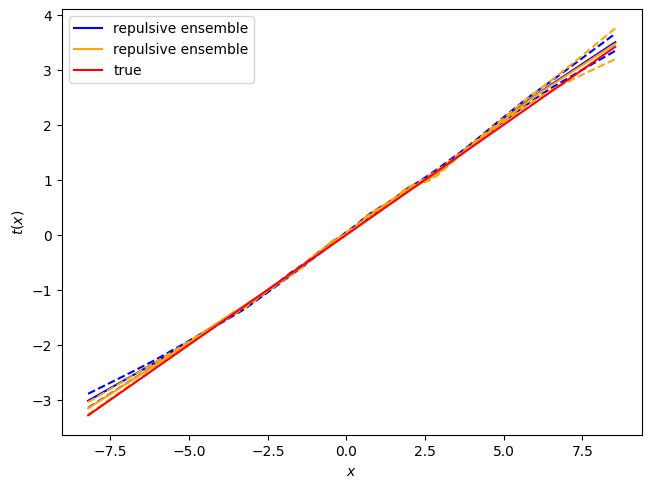

In [55]:
x = np.load("data/x_test.npy")
x = np.sort(x)
t_hat_true = calculate_true_score(x, 0)

fig = plt.figure()

plt.plot(x, t_hat_repulsive_ensemble_sally, c='b', label='repulsive ensemble')
plt.plot(x, t_hat_repulsive_ensemble_sally - t_hat_sig_repulsive_ensemble_sally, c='b', ls='--')
plt.plot(x, t_hat_repulsive_ensemble_sally + t_hat_sig_repulsive_ensemble_sally, c='b', ls='--')

plt.plot(xx.numpy(), repulsive_ensemble_means, c='orange', label='repulsive ensemble')
plt.plot(xx.numpy(), repulsive_ensemble_means - repulsive_ensemble_stds, c='orange', ls='--')
plt.plot(xx.numpy(), repulsive_ensemble_means + repulsive_ensemble_stds, c='orange', ls='--')

plt.plot(x, t_hat_true, c='r', label='true')

plt.legend()

plt.tight_layout()
plt.xlabel(r"$x$")
plt.ylabel(r"$t(x)$")
plt.show()

### Toy model

$p(z|\theta) = \mathcal{N}(z | \theta, \sigma_z = 2)$

$p(x|z) = \mathcal{N}(x | z,\sigma_x = 1)$

true likelihood ratio: $r(x|\theta,\theta_0) = \frac{\mathcal{N}(x | \theta, \sqrt{\sigma_z^2 + \sigma_x^2})}{\mathcal{N}(x | \theta_0, \sqrt{\sigma_z^2 + \sigma_x^2})}$

true score: $t(x|\theta) = 2 \frac{x-\theta}{\sqrt{\sigma_z^2 + \sigma_x^2}}$

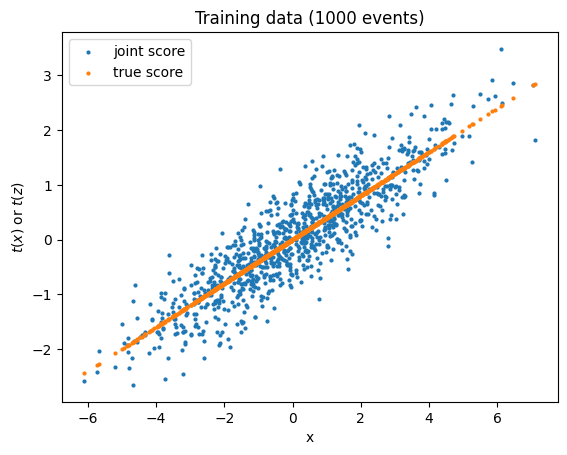

In [27]:
fig, ax = plt.subplots()

plt.scatter(x_train, t_xz_train, label='joint score', s=4)
plt.scatter(x_train, calculate_true_score(x_train, 0.0), label='true score', s=4)
plt.title("Training data (1000 events)")
plt.xlabel(r'x')
plt.ylabel(r'$t(x)$ or $t(z)$')
plt.legend()
plt.show()

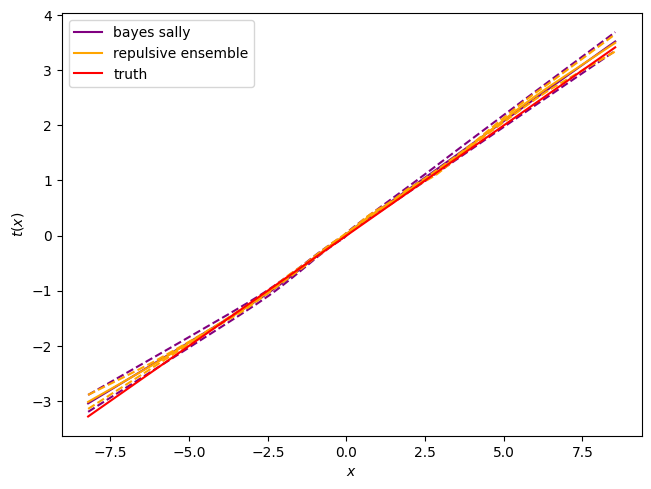

In [72]:
x = np.load("data/x_test.npy")
x = np.sort(x)
t_hat_true = calculate_true_score(x, 0)

fig = plt.figure()

# plt.plot(x, t_hat_heteroskedastic_sally,                                   c='b', label='heteroskedastic sally')
# plt.plot(x, t_hat_heteroskedastic_sally - t_hat_sig_tot_heteroskedastic_sally, c='b', ls='--')
# plt.plot(x, t_hat_heteroskedastic_sally + t_hat_sig_tot_heteroskedastic_sally, c='b', ls='--')
plt.plot(x, t_hat_bayes_sally,                         c='purple', label='bayes sally')
plt.plot(x, t_hat_bayes_sally + t_hat_sig_bayes_sally, c='purple', ls='--')
plt.plot(x, t_hat_bayes_sally - t_hat_sig_bayes_sally, c='purple', ls='--')
# plt.plot(x, t_hat_sally.flatten(), c='darkgreen', label='sally')
# plt.plot(x, t_hat_sally_ensemble, c='cyan', label='sally ensemble')
# plt.plot(x, t_hat_sally_ensemble - t_hat_sig_sally_ensemble, c='cyan', ls='--')
# plt.plot(x, t_hat_sally_ensemble + t_hat_sig_sally_ensemble, c='cyan', ls='--')
plt.plot(x, t_hat_repulsive_ensemble_sally, c='orange', label='repulsive ensemble')
plt.plot(x, t_hat_repulsive_ensemble_sally - t_hat_sig_repulsive_ensemble_sally, c='orange', ls='--')
plt.plot(x, t_hat_repulsive_ensemble_sally + t_hat_sig_repulsive_ensemble_sally, c='orange', ls='--')
plt.plot(x, t_hat_true, c='r', label='truth')

plt.legend()

plt.tight_layout()
plt.xlabel(r"$x$")
plt.ylabel(r"$t(x)$")
plt.show()

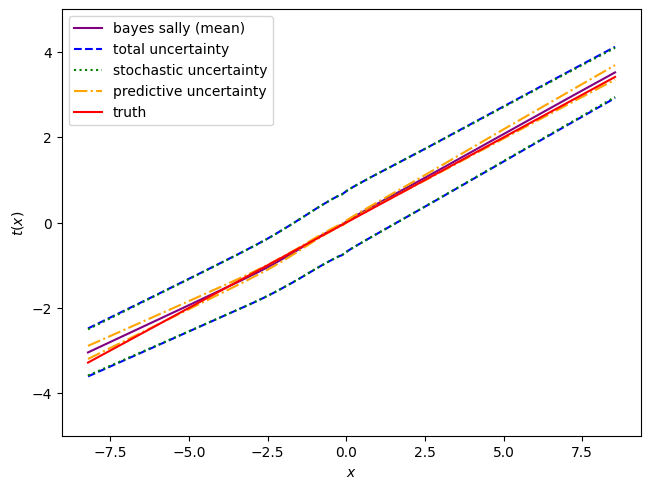

In [70]:
x = np.load("data/x_test.npy")
x = np.sort(x)
t_hat_true = calculate_true_score(x, 0)

fig = plt.figure()

plt.plot(x, t_hat_bayes_sally,                         c='purple', label='bayes sally (mean)')
plt.plot(x, t_hat_bayes_sally + t_hat_sig_tot_bayes_sally, c='b', ls='--', label='total uncertainty')
plt.plot(x, t_hat_bayes_sally - t_hat_sig_tot_bayes_sally, c='b', ls='--')
plt.plot(x, t_hat_bayes_sally + t_hat_sig_stoch_bayes_sally, c='g', ls=':', label='stochastic uncertainty')
plt.plot(x, t_hat_bayes_sally - t_hat_sig_stoch_bayes_sally, c='g', ls=':')
plt.plot(x, t_hat_bayes_sally + t_hat_sig_bayes_sally, c='orange', ls='-.', label='predictive uncertainty')
plt.plot(x, t_hat_bayes_sally - t_hat_sig_bayes_sally, c='orange', ls='-.')
plt.plot(x, t_hat_true, c='r', label='truth')

plt.legend()

plt.tight_layout()
plt.xlabel(r"$x$")
plt.ylabel(r"$t(x)$")
plt.ylim(-5, 5)
plt.show()

# coverage check

In [65]:
from scipy.stats import chi2
from tqdm import tqdm

theta_range = np.linspace(-1, 1, 100)

def calculate_expected_llr(sample, theta):
    return (-2*np.log(calculate_likelihood_ratio(x=sample, theta0=theta))).sum()

def calc_confidence_interval(llr, alpha):
    pvalues = chi2.sf(llr, 1)
    # print(pvalues)
    range_allowed = theta_range[pvalues > 1 - alpha]
    # print(range_allowed)
    if len(range_allowed) == 0:
        return 0, 0
    else:
        return range_allowed.min(), range_allowed.max()

def calc_emperical_coverage(alpha):
    res = []
    for i in range(10):
        sample = simulate(0, npoints=100)[0]
        
        @np.vectorize
        def calculate_llr(theta):
            return calculate_expected_llr(sample, theta)
        
        llr = calculate_llr(theta_range)
        llr -= llr.min()
        conf_interval = calc_confidence_interval(llr, alpha)
        res.append([conf_interval[0] < 0 < conf_interval[1], conf_interval[0], conf_interval[1]])
        # print(conf_interval, conf_interval[0] < 0 < conf_interval[1])
    res = np.array(res)
    return [np.count_nonzero(res[:,0]) / len(res), res[:,1].mean(), res[:,2].mean(), res[:,1].std(), res[:,2].std()]
    
coverages = []
for alpha in tqdm(np.linspace(0, 1, 10)):
    cs = []
    for i in range(10):
        cs.append(calc_emperical_coverage(alpha))
    cs = np.array(cs)
    coverages.append([alpha, cs[:,0].mean(), cs[:,0].std()])
coverages = np.array(coverages)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:44<00:00,  4.46s/it]


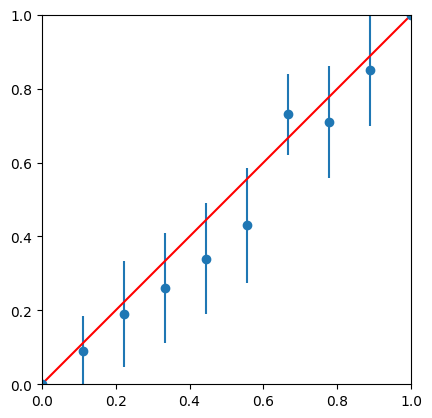

In [67]:
plt.errorbar(coverages[:, 0], coverages[:, 1], yerr=coverages[:, 2], fmt='o')
plt.plot([0, 1], [0, 1], c='r')
plt.axis('square')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

In [ ]:
from scipy.stats import chi2
from tqdm import tqdm

theta_range = np.linspace(-1, 1, 100)

def calculate_expected_llr(sample, theta):
    return (-2*np.log(calculate_likelihood_ratio(x=sample, theta0=theta))).sum()

def calc_confidence_interval(llr, alpha):
    pvalues = chi2.sf(llr, 1)
    # print(pvalues)
    range_allowed = theta_range[pvalues > 1 - alpha]
    # print(range_allowed)
    if len(range_allowed) == 0:
        return 0, 0
    else:
        return range_allowed.min(), range_allowed.max()

def calc_emperical_coverage(alpha):
    res = []
    for i in range(10):
        sample = simulate(0, npoints=100)[0]
        
        @np.vectorize
        def calculate_llr(theta):
            return calculate_expected_llr(sample, theta)
        
        llr, ll = repulsive_ensemble_sally.evaluate(theta=theta_range, x=sample)
        llr -= llr.min()
        conf_interval = calc_confidence_interval(llr, alpha)
        res.append([conf_interval[0] < 0 < conf_interval[1], conf_interval[0], conf_interval[1]])
        # print(conf_interval, conf_interval[0] < 0 < conf_interval[1])
    res = np.array(res)
    return [np.count_nonzero(res[:,0]) / len(res), res[:,1].mean(), res[:,2].mean(), res[:,1].std(), res[:,2].std()]
    
coverages = []
for alpha in tqdm(np.linspace(0, 1, 10)):
    cs = []
    for i in range(10):
        cs.append(calc_emperical_coverage(alpha))
    cs = np.array(cs)
    coverages.append([alpha, cs[:,0].mean(), cs[:,0].std()])
coverages = np.array(coverages)